In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import shap
import xgboost as xgb

In [5]:
file_path = r'C:\Users\milto\OneDrive\Desktop\Health Informatics\Artificial Intelligence in Health Care\Projects\Dataset\GDSC_DATASET.csv'
data = pd.read_csv(file_path)
data.head()


,COSMIC_ID,CELL_LINE_NAME,TCGA_DESC,DRUG_ID,DRUG_NAME,LN_IC50,AUC,Z_SCORE,GDSC Tissue descriptor 1,GDSC Tissue descriptor 2,Cancer Type (matching TCGA label),Microsatellite instability Status (MSI),Screen Medium,Growth Properties,CNA,Gene Expression,Methylation,TARGET,TARGET_PATHWAY
0,683667,PFSK-1,MB,1003,Camptothecin,-1.463887,0.930220,0.433123,nervous_system,medulloblastoma,MB,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
1,684057,ES5,UNCLASSIFIED,1003,Camptothecin,-3.360586,0.791072,-0.599569,bone,ewings_sarcoma,NaN,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
2,684059,ES7,UNCLASSIFIED,1003,Camptothecin,-5.044940,0.592660,-1.516647,bone,ewings_sarcoma,NaN,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
3,684062,EW-11,UNCLASSIFIED,1003,Camptothecin,-3.741991,0.734047,-0.807232,bone,ewings_sarcoma,NaN,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
4,684072,SK-ES-1,UNCLASSIFIED,1003,Camptothecin,-5.142961,0.582439,-1.570016,bone,ewings_sarcoma,NaN,MSS/MSI-L,R,Semi-Adherent,Y,Y,Y,TOP1,DNA replication


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242035 entries, 0 to 242034
Data columns (total 19 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   COSMIC_ID                                242035 non-null  int64  
 1   CELL_LINE_NAME                           242035 non-null  object 
 2   TCGA_DESC                                240968 non-null  object 
 3   DRUG_ID                                  242035 non-null  int64  
 4   DRUG_NAME                                242035 non-null  object 
 5   LN_IC50                                  242035 non-null  float64
 6   AUC                                      242035 non-null  float64
 7   Z_SCORE                                  242035 non-null  float64
 8   GDSC Tissue descriptor 1                 232669 non-null  object 
 9   GDSC Tissue descriptor 2                 232669 non-null  object 
 10  Cancer Type (matching TCGA label

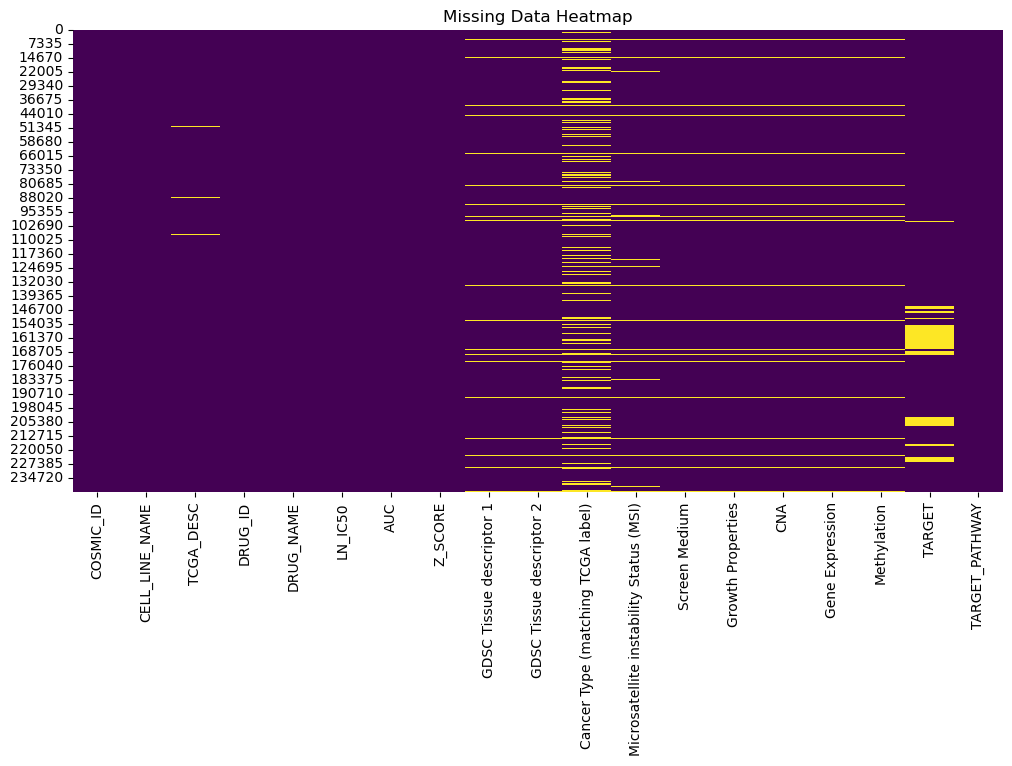

In [7]:
# Show basic info and null values
print(data.info())
print(data.isnull().sum())

# Visualize null values
plt.figure(figsize=(12,6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Data Heatmap")
plt.show()


In [9]:
drop_columns = ['COSMIC_ID', 'CELL_LINE_NAME', 'TCGA_DESC']  # Adjust based on your dataset
data = data.drop(columns=[col for col in drop_columns if col in data.columns])

In [11]:
# Convert Z_SCORE to binary class: 0 = Sensitive, 1 = Resistant
data['Drug_Sensitivity'] = np.where(data['Z_SCORE'] > 0, 1, 0)

# Drop Z_SCORE
data = data.drop(columns=['Z_SCORE'])

In [13]:
# Drop any remaining rows with missing values
data = data.dropna()
print(f"Data shape after dropping NA: {data.shape}")

Data shape after dropping NA: (167004, 16)


In [15]:
# One-hot encoding for categorical variables
data_encoded = pd.get_dummies(data, drop_first=True)


In [17]:
X = data_encoded.drop(columns=['Drug_Sensitivity'])
y = data_encoded['Drug_Sensitivity']

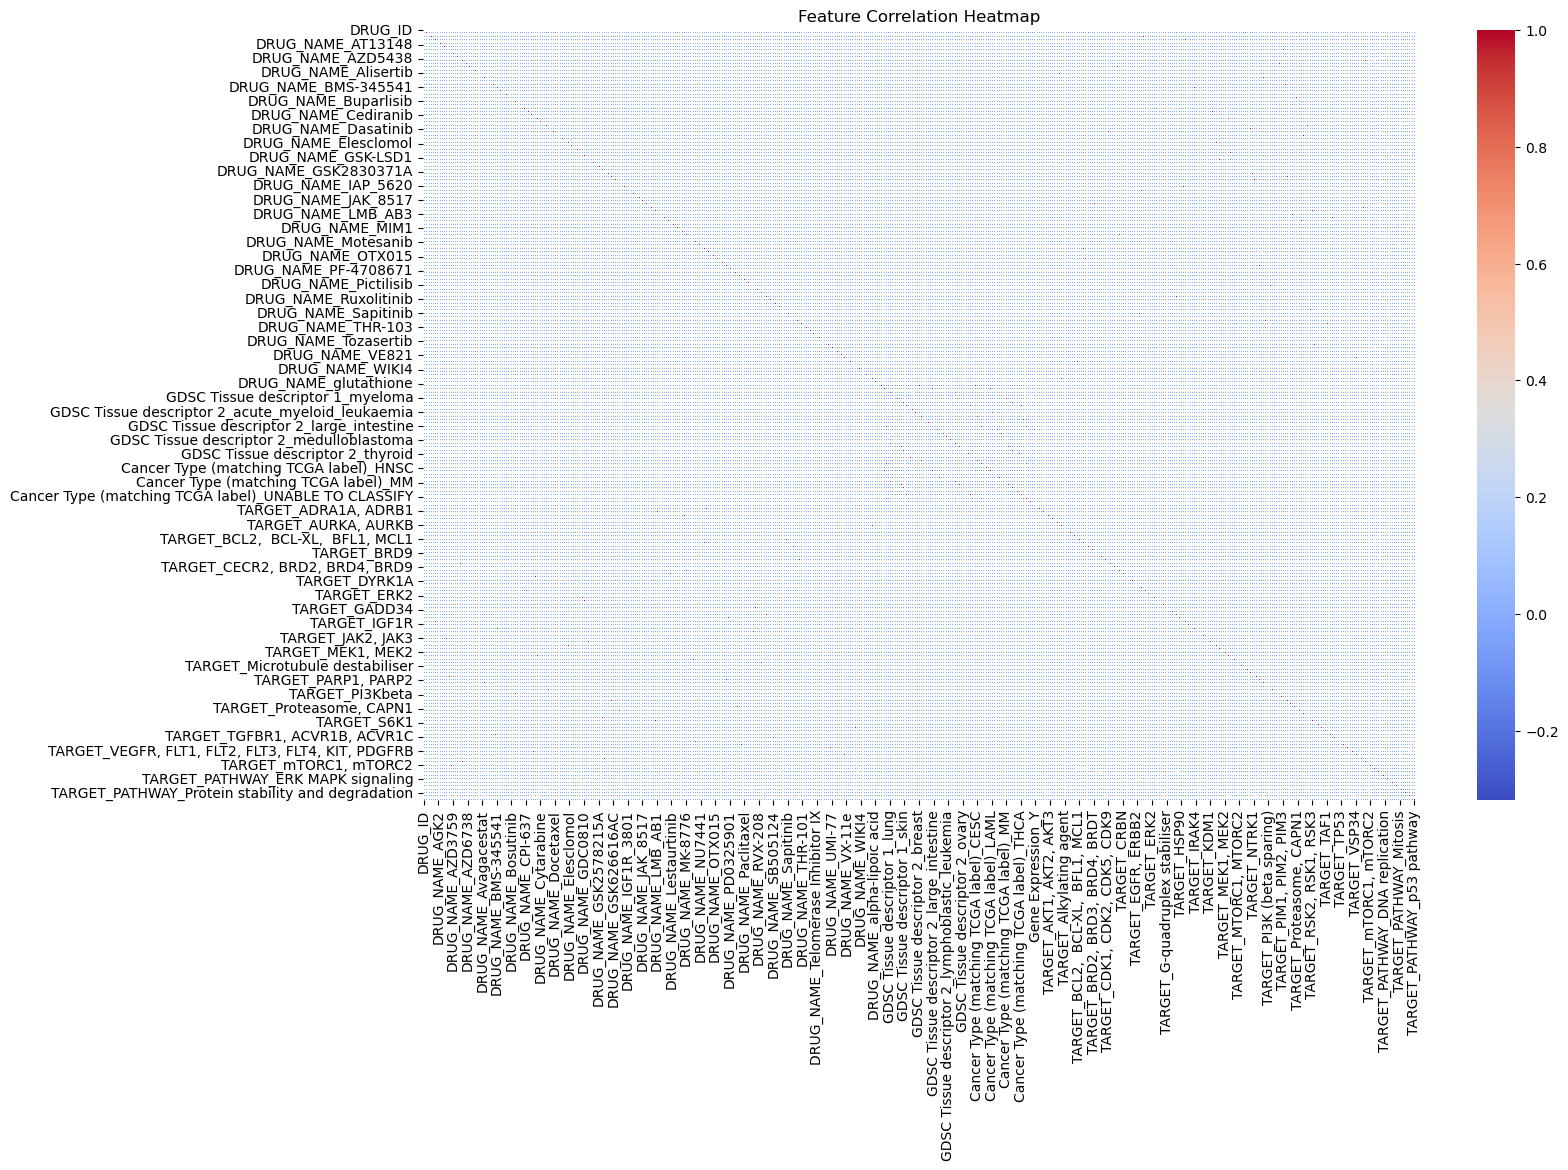

In [19]:
plt.figure(figsize=(16, 10))
sns.heatmap(X.corr(), cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training size: {X_train.shape}, Test size: {X_test.shape}")

Training size: (133603, 545), Test size: (33401, 545)


C:\Users\milto\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


🔍 Logistic Regression Metrics
Accuracy: 0.7759647914733092
Precision: 0.8058993780405197
Recall: 0.7513491790102194
F1 Score: 0.7776688356062632

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.80      0.77     15983
           1       0.81      0.75      0.78     17418

    accuracy                           0.78     33401
   macro avg       0.78      0.78      0.78     33401
weighted avg       0.78      0.78      0.78     33401



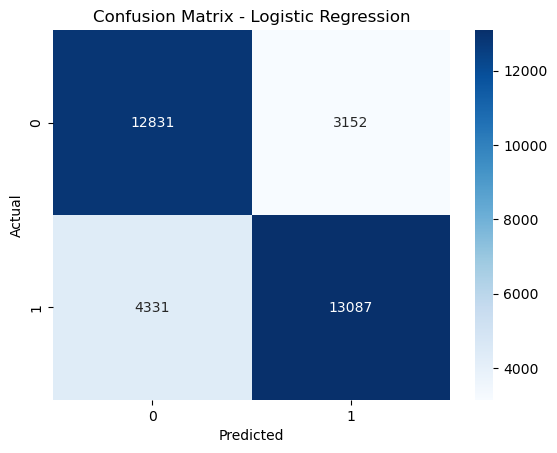

In [25]:
# Train Logistic Regression
log_model = LogisticRegression(max_iter=100)
log_model.fit(X_train, y_train)
log_pred = log_model.predict(X_test)

# Evaluate performance
from sklearn.metrics import classification_report, confusion_matrix

print("🔍 Logistic Regression Metrics")
print("Accuracy:", accuracy_score(y_test, log_pred))
print("Precision:", precision_score(y_test, log_pred))
print("Recall:", recall_score(y_test, log_pred))
print("F1 Score:", f1_score(y_test, log_pred))
print("\nClassification Report:\n", classification_report(y_test, log_pred))

# Confusion Matrix
cm_log = confusion_matrix(y_test, log_pred)
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

🔍 Random Forest Metrics
Accuracy: 0.959342534654651
Precision: 0.9632514134071767
Recall: 0.9586060397290159
F1 Score: 0.9609231123388582

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96     15983
           1       0.96      0.96      0.96     17418

    accuracy                           0.96     33401
   macro avg       0.96      0.96      0.96     33401
weighted avg       0.96      0.96      0.96     33401



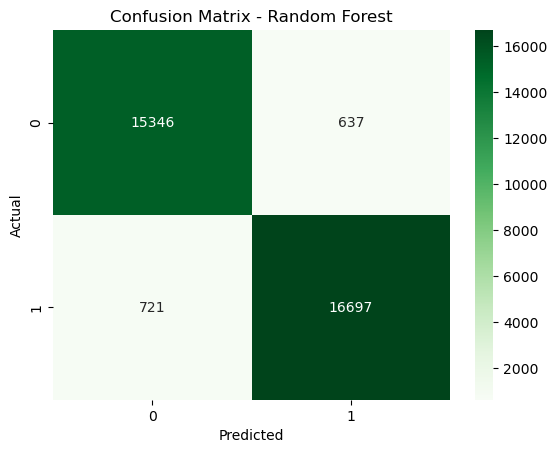

In [27]:
# Train Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

print("🔍 Random Forest Metrics")
print("Accuracy:", accuracy_score(y_test, rf_pred))
print("Precision:", precision_score(y_test, rf_pred))
print("Recall:", recall_score(y_test, rf_pred))
print("F1 Score:", f1_score(y_test, rf_pred))
print("\nClassification Report:\n", classification_report(y_test, rf_pred))

cm_rf = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

C:\Users\milto\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:55:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🔍 XGBoost Metrics
Accuracy: 0.9723361576000719
Precision: 0.9769257460097155
Recall: 0.9698587667929728
F1 Score: 0.9733794295592049

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97     15983
           1       0.98      0.97      0.97     17418

    accuracy                           0.97     33401
   macro avg       0.97      0.97      0.97     33401
weighted avg       0.97      0.97      0.97     33401



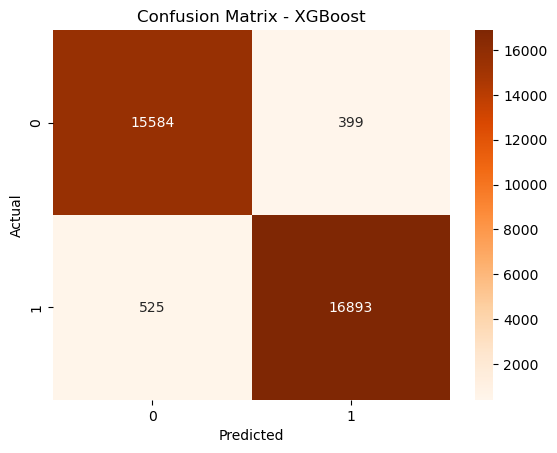

In [29]:
# Train XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

print("🔍 XGBoost Metrics")
print("Accuracy:", accuracy_score(y_test, xgb_pred))
print("Precision:", precision_score(y_test, xgb_pred))
print("Recall:", recall_score(y_test, xgb_pred))
print("F1 Score:", f1_score(y_test, xgb_pred))
print("\nClassification Report:\n", classification_report(y_test, xgb_pred))

cm_xgb = confusion_matrix(y_test, xgb_pred)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


🔍 KNN Metrics
Accuracy: 0.9104218436573756
Precision: 0.9094108298331253
Recall: 0.9198530256056953
F1 Score: 0.9146021235300833

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.90      0.91     15983
           1       0.91      0.92      0.91     17418

    accuracy                           0.91     33401
   macro avg       0.91      0.91      0.91     33401
weighted avg       0.91      0.91      0.91     33401



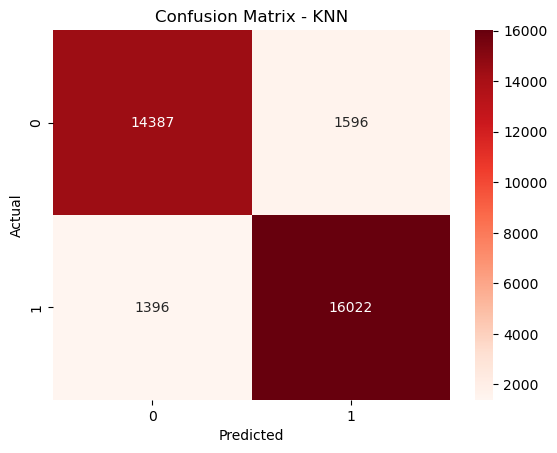

In [31]:
# Train KNN
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)

print("🔍 KNN Metrics")
print("Accuracy:", accuracy_score(y_test, knn_pred))
print("Precision:", precision_score(y_test, knn_pred))
print("Recall:", recall_score(y_test, knn_pred))
print("F1 Score:", f1_score(y_test, knn_pred))
print("\nClassification Report:\n", classification_report(y_test, knn_pred))

cm_knn = confusion_matrix(y_test, knn_pred)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Reds')
plt.title("Confusion Matrix - KNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
import shap

# SHAP explainer for tree-based models
explainer = shap.TreeExplainer(rf_model)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

In [ ]:
shap.summary_plot(shap_values[1], X_test)

In [ ]:
# Summary plot
shap.summary_plot(shap_values[1], X_test, plot_type="bar")  


In [ ]:
# plot for a single prediction
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_test.iloc[0])
